Big Data Mart Sales Problem
Problem Statement:
The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing the sales of their products.

The dataset includes two files:

- bigdatamart_Train.csv: Use this file for the model building purpose. 

- bigdatamart_Test.csv: Use this file for getting predictions from the trained model. 

Note: You can find the dataset in the link below.

In [1]:
    # importing required libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# reading train and test data
train_data = pd.read_csv('bigdatamart_Train.csv')
test_data = pd.read_csv('bigdatamart_Test.csv')

In [3]:
train_data.shape

(8523, 12)

In [4]:
test_data.shape

(5681, 11)

train dataset has 8523 rows and 12 features and test has 5681 rows and 11 columns. train has 1 extra column which is the target variable. We will predict this target variable for the test dataset later in this tutorial.



In [5]:
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
#statistical description of the data
train_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


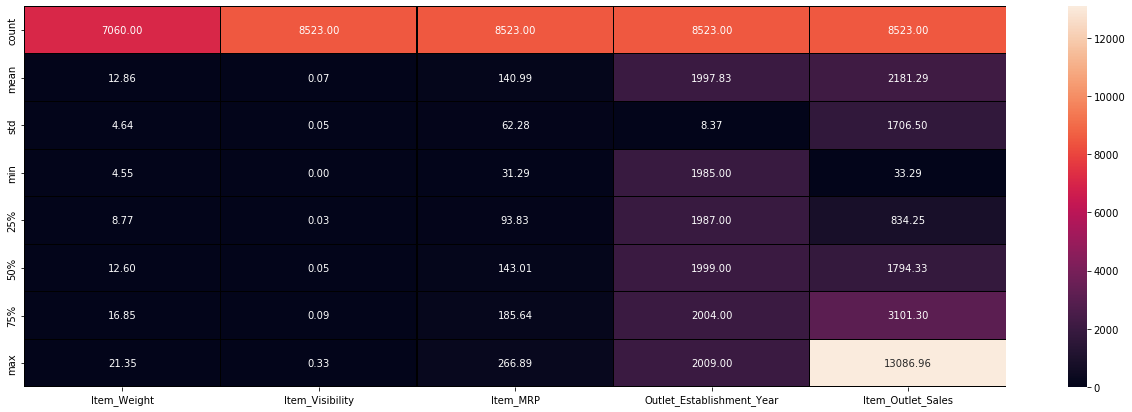

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(22,7))
sns.heatmap(train_data.describe(),annot=True,linewidth=0.1,linecolor="black",fmt="0.2f")


The statistical descriptive summary seems fine as we do not see any invalid values. But we see some data needs standarization as they are in different scales.



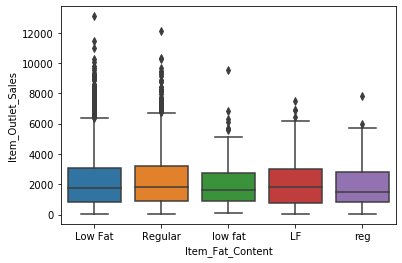

In [8]:
#as we combined all kind of names of Low Fat and Regular Fat, so now we should have only 2 kind of item fat content: LOw Fat and Regular and check their outliers
import matplotlib.pyplot as plt
ax = sns.boxplot(x="Item_Fat_Content", y="Item_Outlet_Sales", data=train_data)
plt.show()

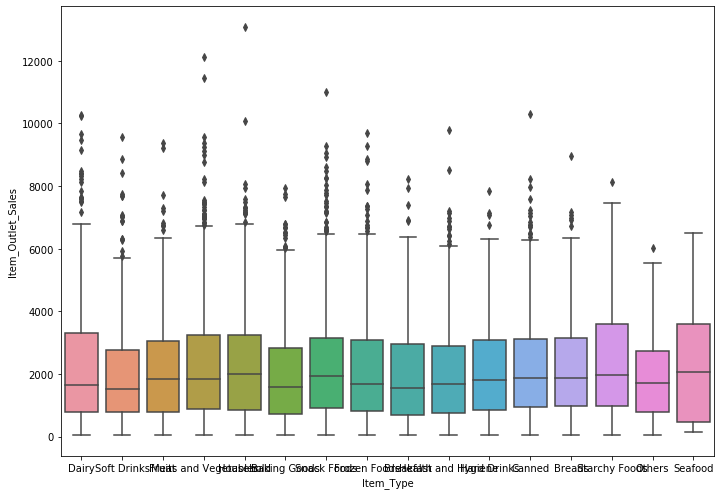

In [9]:
#Now let’s check the other categorical variables. and check thir outliers
import matplotlib.pyplot as plt
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.boxplot(x="Item_Type", y="Item_Outlet_Sales", data=train_data)
plt.show()

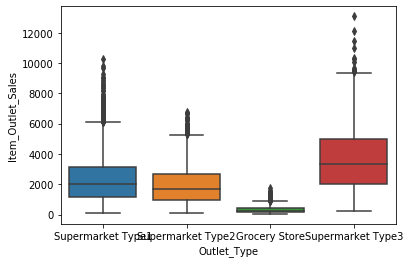

In [10]:
import matplotlib.pyplot as plt #let's plot outlet type in relation to outlet sales and check their outliers.
ax = sns.boxplot(x="Outlet_Type", y="Item_Outlet_Sales", data=train_data)
plt.show()

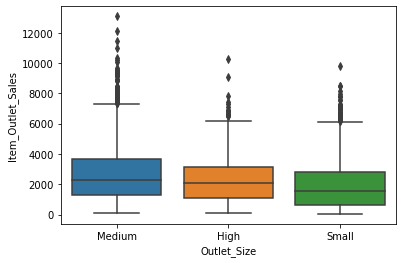

In [11]:
import matplotlib.pyplot as plt
ax = sns.boxplot(x="Outlet_Size", y="Item_Outlet_Sales", data=train_data)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02ddb3f0d0>,
      dtype=object)

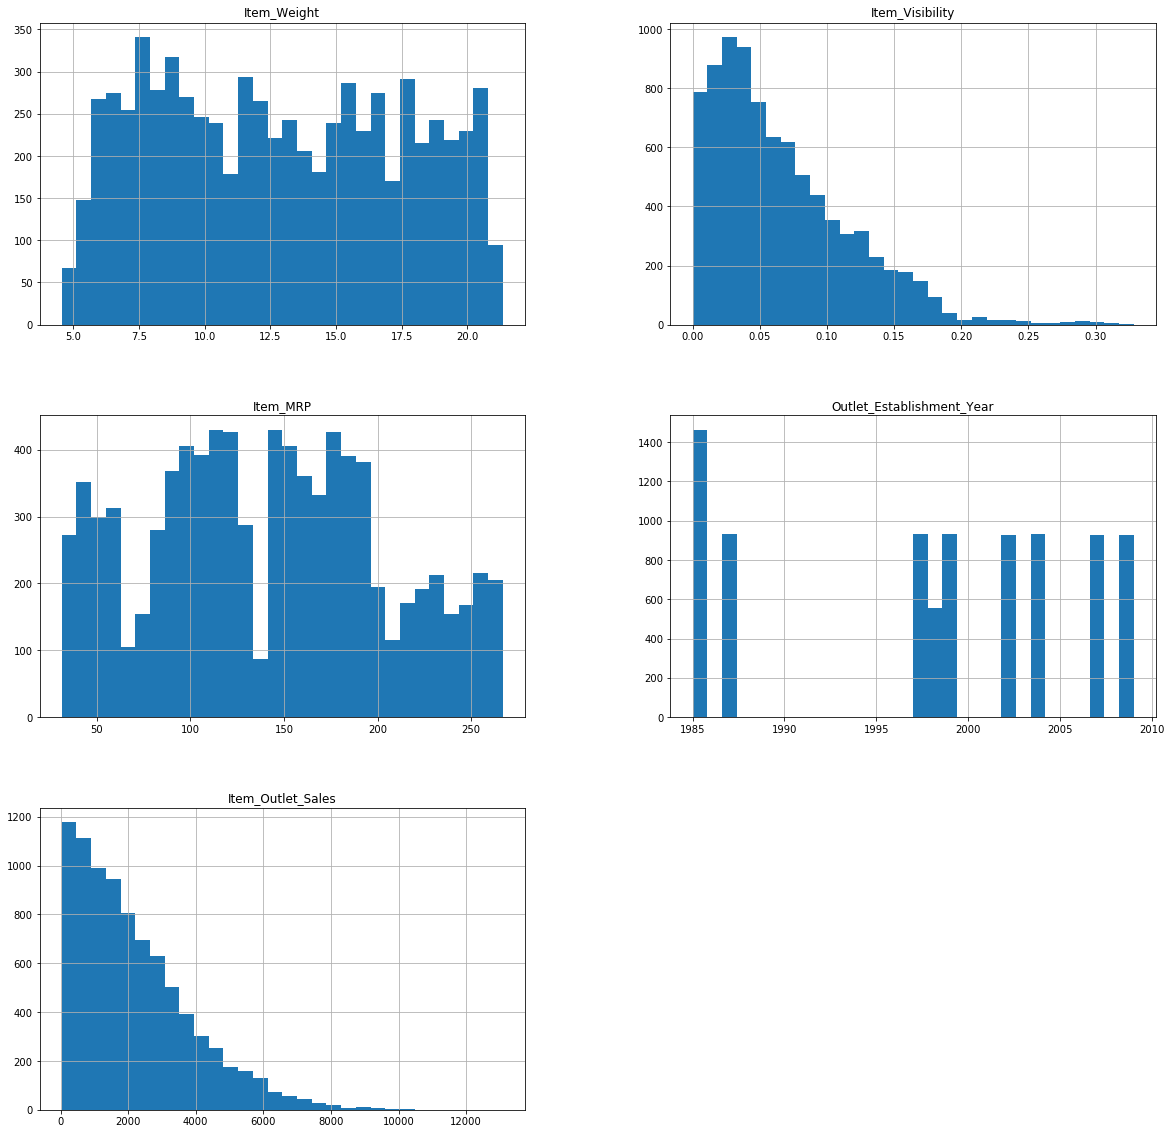

In [12]:
'''Histogram : to see the numeric data distribution'''
train_data.hist(figsize=(20,20), grid = True, bins = 30)



In [13]:
#we see skewness in the above grafs. so, let's go and select numerical columns. as we said, all the columns excluding the target quality_desc are numerical columns
nf = train_data.select_dtypes(include=[np.number]).columns
nf

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [14]:
#let's check skewness
from scipy.stats import skew
df=train_data
skew_list = skew(df[nf],nan_policy='omit') #sending all numericalfeatures and omitting nan values
skew_list_df = pd.concat([pd.DataFrame(nf,columns=['Features']),pd.DataFrame(skew_list,columns=['Skewness'])],axis = 1)

In [15]:
skew_list_df.sort_values(by='Skewness', ascending = False)

,Features,Skewness
4,Item_Outlet_Sales,1.177323
1,Item_Visibility,1.166885
2,Item_MRP,0.127180
0,Item_Weight,0.082409
3,Outlet_Establishment_Year,-0.396571


In [16]:
cf = train_data.select_dtypes(include=[np.object]).columns

cf

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


We can see that, all 12 columns are of numeric data types. Out of 12 variables, 11 are predictor variables and last one 'quality' is the target variable. The dataset is fine since there are no null values and all data is in type numerical float type (we dont have any object type that we need to convert to numerical type).



In [18]:
train_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [19]:
train_data['Outlet_Size'] = train_data['Outlet_Size'].fillna(train_data['Outlet_Size'].mode()[0])

In [20]:
'''import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

train_data.fillna(0)
# creating instance of one-hot-encoder
enc = OneHotEncoder()
# passing categorical column for encoding
enc_df = pd.DataFrame(enc.fit_transform(train_data[['Item_Identifier','Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type']]).toarray())

# merge with main train_data  on key values
train_data = train_data.join(enc_df)
train_data'''

"import pandas as pd\nimport numpy as np\nfrom sklearn.preprocessing import OneHotEncoder\n\ntrain_data.fillna(0)\n# creating instance of one-hot-encoder\nenc = OneHotEncoder()\n# passing categorical column for encoding\nenc_df = pd.DataFrame(enc.fit_transform(train_data[['Item_Identifier','Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type']]).toarray())\n\n# merge with main train_data  on key values\ntrain_data = train_data.join(enc_df)\ntrain_data"

In [21]:

#let's transform the quality_desc and encode and convert it to numerical
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
train_data['Item_Identifier'] = labelencoder.fit_transform(train_data['Item_Identifier'])
train_data['Item_Fat_Content'] = labelencoder.fit_transform(train_data['Item_Fat_Content'])
train_data['Item_Type'] = labelencoder.fit_transform(train_data['Item_Type'])
train_data['Outlet_Identifier'] = labelencoder.fit_transform(train_data['Outlet_Identifier'])
train_data['Outlet_Size'] = labelencoder.fit_transform(train_data['Outlet_Size'])
train_data['Outlet_Location_Type'] = labelencoder.fit_transform(train_data['Outlet_Location_Type'])
train_data['Outlet_Type'] = labelencoder.fit_transform(train_data['Outlet_Type'])

train_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.300,1,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.920,2,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.500,1,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.200,2,0.000000,6,182.0950,0,1998,1,2,0,732.3800
4,1297,8.930,1,0.000000,9,53.8614,1,1987,0,2,1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,370,6.865,1,0.056783,13,214.5218,1,1987,0,2,1,2778.3834
8519,897,8.380,2,0.046982,0,108.1570,7,2002,1,1,1,549.2850
8520,1357,10.600,1,0.035186,8,85.1224,6,2004,2,1,1,1193.1136
8521,681,7.210,2,0.145221,13,103.1332,3,2009,1,2,2,1845.5976


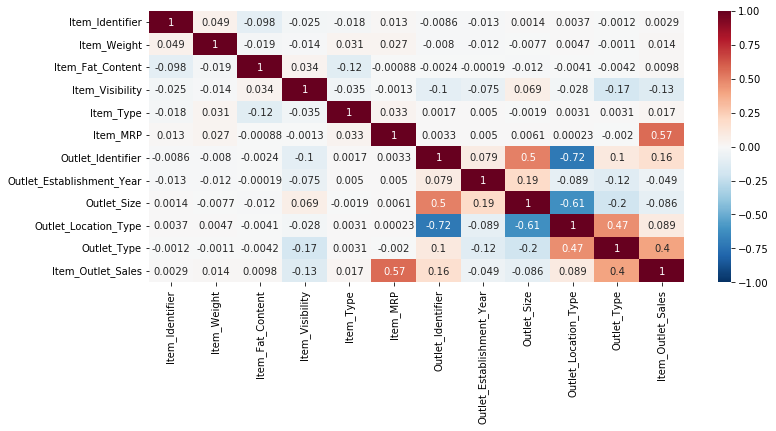

In [22]:
#Corelation between features/variables:¶
correlation = train_data.corr()
plt.figure(figsize=(12, 5))
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

Variables Outlet_type and Item_MRP are highly correlated with regards Item Outlet Sales.

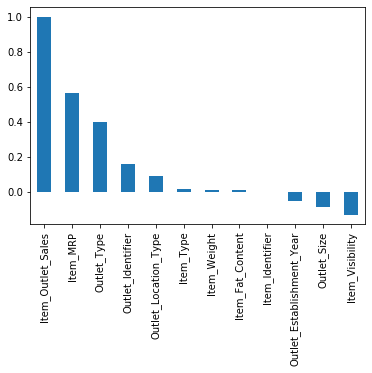

In [23]:
correlations =train_data.corr()['Item_Outlet_Sales'].sort_values(ascending=False)
correlations.plot(kind='bar')

Now let's check for the missing values:

In [24]:
correlations[abs(correlations) > 0.2]

Item_Outlet_Sales    1.000000
Item_MRP             0.567574
Outlet_Type          0.401522
Name: Item_Outlet_Sales, dtype: float64

In [25]:
train_data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [26]:
asasas

NameError: name 'asasas' is not defined

In [27]:
'''Missing Values '''
miss_df = train_data.isnull().sum().sort_values(ascending = False)
miss_df

Item_Weight                  1463
Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [28]:
train_data['Item_Weight'] = train_data['Item_Weight'].fillna(train_data['Item_Weight'].mean())

In [29]:
'''Missing Values '''
miss_df = train_data.isnull().sum().sort_values(ascending = False)
miss_df

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [42]:
'''Missing Values '''
miss_df = test_data.isnull().sum().sort_values(ascending = False)
miss_df

Outlet_Size                  1606
Item_Weight                   976
Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [43]:
test_data['Item_Weight'] = test_data['Item_Weight'].fillna(test_data['Item_Weight'].mean())
'''Missing Values '''
miss_df = test_data.isnull().sum().sort_values(ascending = False)
miss_df

Outlet_Size                  1606
Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [44]:
test_data['Outlet_Size'] = test_data['Outlet_Size'].fillna(test_data['Outlet_Size'].mode()[0])
miss_df = test_data.isnull().sum().sort_values(ascending = False)
miss_df

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [51]:
#Checking the outliers and removing them:
from scipy.stats import zscore
import numpy as np
z=np.abs(zscore(df))
z.shape

(8523, 12)

In [52]:
threhold=3
print(np.where(z>3))

(array([  49,   81,   83,  108,  130,  145,  151,  174,  199,  276,  304,
        333,  339,  373,  396,  434,  456,  472,  489,  502,  521,  532,
        615,  661,  694,  727,  753,  753,  809,  838,  854,  891,  935,
        991,  997, 1009, 1010, 1034, 1090, 1124, 1133, 1138, 1159, 1183,
       1209, 1254, 1272, 1291, 1311, 1324, 1372, 1433, 1434, 1450, 1496,
       1501, 1506, 1512, 1542, 1549, 1560, 1575, 1576, 1615, 1617, 1644,
       1651, 1684, 1723, 1753, 1769, 1805, 1827, 1841, 1859, 1998, 2062,
       2088, 2109, 2111, 2122, 2143, 2168, 2173, 2216, 2223, 2238, 2251,
       2293, 2324, 2331, 2438, 2439, 2445, 2516, 2535, 2552, 2569, 2586,
       2613, 2660, 2678, 2728, 2776, 2855, 2895, 2905, 2971, 2973, 3011,
       3017, 3083, 3087, 3098, 3154, 3206, 3225, 3234, 3241, 3242, 3243,
       3286, 3335, 3367, 3399, 3407, 3458, 3474, 3480, 3488, 3491, 3497,
       3509, 3540, 3545, 3582, 3602, 3667, 3709, 3720, 3750, 3757, 3767,
       3884, 3993, 4006, 4019, 4083, 4163, 4219, 4

In [53]:
#checking the dataset shape (with outliers and with outliers)
df_new=df[(z<3).all(axis=1)]
print(df.shape)
print(df_new.shape)

(8523, 12)
(8222, 12)


In [54]:
#Percentage of data loss:
loss_perc=(8523-8222)/8523*100
loss_perc #since the loss < 10%, so we can proceed with removing the outliers.

3.5316203214830457

In [55]:
#Now let's split the data by features (X, all except Item_Outlet_Sales Column) and target outcome (Y, Item_Outlet_Sales)

X=df_new.drop(['Item_Outlet_Sales'],axis=1)
Y=df_new['Item_Outlet_Sales']

In [56]:

#Transforming the data to remove the skewness:
from sklearn.preprocessing import power_transform
x=power_transform(X,method='yeo-johnson')

/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [57]:
#now we will standardrize the data 
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x=sc.fit_transform(x)
x

array([[-1.45691592, -0.81766493, -0.55319135, ..., -0.28893369,
        -1.37620889, -0.13508106],
       [-2.08876736, -1.72429666,  1.16170169, ..., -0.28893369,
         1.0952949 ,  1.05485046],
       [-0.15559082,  1.07935446, -0.55319135, ..., -0.28893369,
        -1.37620889, -0.13508106],
       ...,
       [ 1.19648612, -0.49341756, -0.55319135, ...,  1.39061522,
        -0.1266511 , -0.13508106],
       [-0.11435156, -1.36561856,  1.16170169, ..., -0.28893369,
         1.0952949 ,  1.05485046],
       [-1.85741534,  0.48880913, -0.55319135, ...,  1.39061522,
        -1.37620889, -0.13508106]])

In [58]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_new[list(df_new.columns[:-2])]

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(x, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
9,5.436675,Outlet_Location_Type
6,4.714211,Outlet_Identifier
8,1.732570,Outlet_Size
7,1.052816,Outlet_Establishment_Year
3,1.027065,Item_Visibility
2,1.024795,Item_Fat_Content
4,1.022789,Item_Type
0,1.010080,Item_Identifier
1,1.004755,Item_Weight
5,1.003069,Item_MRP


In [38]:
#so we do not have multicolinearity. Good!

In [59]:
#split data in training and testing 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.3, random_state=0)

In [63]:
#Building Machine Learning Models
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
for i in range(0,10):
    X_train, X_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.3, random_state=i)
    lr.fit(X_train,Y_train)
    pred_train=lr.predict(X_train)
    pred_test=lr.predict(X_test)
    print(f"At random state {i}, the training accuracy is:  {r2_score(Y_train,pred_train)}")
    print(f"At random state {i}, the testing accuracy is:  {r2_score(Y_test,pred_test)}")
    print("\n")

At random state 0, the training accuracy is:  0.5170796895744934
At random state 0, the testing accuracy is:  0.5149668820636668


At random state 1, the training accuracy is:  0.5193047251159603
At random state 1, the testing accuracy is:  0.5086039372584702


At random state 2, the training accuracy is:  0.5170932943091948
At random state 2, the testing accuracy is:  0.5150011688445673


At random state 3, the training accuracy is:  0.5244836019614139
At random state 3, the testing accuracy is:  0.49755286744973304


At random state 4, the training accuracy is:  0.5142160876940096
At random state 4, the testing accuracy is:  0.5207285347269093


At random state 5, the training accuracy is:  0.5215803706634046
At random state 5, the testing accuracy is:  0.504084681253326


At random state 6, the training accuracy is:  0.5074550057941034
At random state 6, the testing accuracy is:  0.535936674936798


At random state 7, the training accuracy is:  0.5210509353622097
At random state 7, 

In [60]:
#let's take radom state of 2

from sklearn.linear_model import LinearRegression
lr=LinearRegression()
X_train, X_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.3, random_state=2)
lr.fit(X_train,Y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
from sklearn.metrics import r2_score
pred_test=lr.predict(X_test)
print(r2_score(Y_test,pred_test))

0.5150011688445673


In [64]:
#Cross validation of the model:
Train_accuracy=r2_score(Y_train,pred_train)
Test_accuracy=r2_score(Y_test,pred_test)

from sklearn.model_selection import cross_val_score
for j in range(2,20):
    cv_score=cross_val_score(lr,x,Y,cv=j)
    cv_mean=cv_score.mean()
    print(f"At cross fold {j} the CV score is {cv_mean} and accuracy score for training is {Train_accuracy} and accuracy for the testing is {Test_accuracy}")
    print("\n")

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Depreca

At cross fold 2 the CV score is 0.5146402184753146 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281


At cross fold 3 the CV score is 0.5147280599359375 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(

At cross fold 4 the CV score is 0.5138355494542909 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Depreca

At cross fold 5 the CV score is 0.5145481126605256 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Depreca

At cross fold 6 the CV score is 0.5148857486284867 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(

At cross fold 7 the CV score is 0.5150948734850581 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(

At cross fold 8 the CV score is 0.5146067432816885 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(

At cross fold 9 the CV score is 0.5146309049823574 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(

At cross fold 10 the CV score is 0.5146158956644855 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281


At cross fold 11 the CV score is 0.5146392337332157 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(

At cross fold 12 the CV score is 0.5146223105260976 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(

At cross fold 13 the CV score is 0.5134939608195295 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(

At cross fold 14 the CV score is 0.5137888794118451 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(

At cross fold 15 the CV score is 0.5142946517303695 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(

At cross fold 16 the CV score is 0.5142266881840372 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(

At cross fold 17 the CV score is 0.5136478767580646 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(

At cross fold 18 the CV score is 0.5130519076903225 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(

At cross fold 19 the CV score is 0.5133474186033204 and accuracy score for training is 0.5163910193854346 and accuracy for the testing is 0.5160330937997281




In [65]:
#Regularization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings 
warnings.filterwarnings('ignore')

In [66]:
#we will cross validate with Lasso techniquue
from sklearn.linear_model import Lasso
parameters={ 'alpha':[.0001,.001,.01,.1,1,10], 'random_state': list(range(0,10))}
ls=Lasso()
clf=GridSearchCV(ls,parameters)
clf.fit(X_train,Y_train)
print(clf.best_params_)

{'alpha': 1, 'random_state': 0}


In [68]:
ls=Lasso(alpha=1,random_state=0)
ls.fit(X_train,Y_train)
ls.score(X_train,Y_train)
pred_ls=ls.predict(X_test)
lss=r2_score(Y_test,pred_ls)
lss

0.5161659319560505

In [69]:
#best cross fold is 4
cv_score=cross_val_score(ls,x,Y,cv=7)
cv_mean=cv_score.mean()
cv_mean

0.5151466188715367

In [70]:
#Ensemble Technique:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

parameters={'criterion':['mse','mae'],'max_features':["auto","sqrt","log2"]}
rf=RandomForestRegressor()
clf=GridSearchCV(rf,parameters)
clf.fit(X_train,Y_train)
print(clf.best_params_)

{'criterion': 'mse', 'max_features': 'sqrt'}


In [71]:

rf=RandomForestRegressor(criterion="mse",max_features="sqrt")
rf.fit(X_train,Y_train)
rf.score(X_train,Y_train)
pred_decision=rf.predict(X_test)

rfs=r2_score(Y_test,pred_decision)
print('R2 score:',rfs*100)

rfscore=cross_val_score(rf,x,Y, cv=5)
rfc=rfscore.mean()
print('Cross Val Score:', rfc*100)

pred_test=rf.predict(X_test)
print(r2_score(Y_test,pred_test))

R2 score: 52.63128276965902
Cross Val Score: 51.97423481626251
0.5263128276965903


In [116]:
import pickle
filename='Mart.pkl'
pickle.dump(rf,open(filename,'wb'))

In [117]:

#Conslusion
import pickle
loaded_model=pickle.load(open('Mart.pkl','rb'))
result=loaded_model.score(X_test,Y_test)
print(result)

0.5263128276965903


In [118]:
Conclusion=pd.DataFrame([loaded_model.predict(X_test)[:],pred_decision[:]],index=["Predicted","Original"])


In [119]:
Conclusion

,0,1,2,3,4,5,6,7,8,9,...,2457,2458,2459,2460,2461,2462,2463,2464,2465,2466
Predicted,2496.15078,1456.97014,2925.32546,534.23792,3761.03762,2241.68202,2777.58444,3832.07848,177.50228,1869.49982,...,1559.70308,1694.99364,1256.16486,4725.04944,467.25844,497.81866,3577.80946,106.8609,826.39096,395.8181
Original,2496.15078,1456.97014,2925.32546,534.23792,3761.03762,2241.68202,2777.58444,3832.07848,177.50228,1869.49982,...,1559.70308,1694.99364,1256.16486,4725.04944,467.25844,497.81866,3577.80946,106.8609,826.39096,395.8181
